<h1 align="center">Klasifikasi Penyakit Pneumonia dan Covid pada X-Ray Paru-Paru Menggunakan Metode GLCM dan Fully Connected dari CNN</h1>

Kelompok:

- Amdila Rahmadi (F1D021078)
- M. Afdhol Gilman (F1D021106)
- Muhammad Fahir (F1D021121)

## Libraries:
- os: Modul untuk berinteraksi dengan sistem operasi, seperti mengelola path file.
- cv2: OpenCV untuk pengolahan gambar dan komputer vision.
- numpy: Operasi array dan matriks untuk komputasi numerik.
- pandas: Struktur data dan analisis data.
- matplotlib.pyplot: Visualisasi data seperti plotting.
- PIL.Image: Modul untuk memanipulasi gambar.
- seaborn: Visualisasi data berbasis matplotlib untuk membuat grafik statistik.
- random: Fungsi-fungsi acak untuk menghasilkan bilangan acak.
- graycomatrix, graycoprops: Fungsi-fungsi dari skimage untuk ekstraksi fitur dari citra menggunakan matriks ko-ocurrence.
- train_test_split: Dari sklearn.model_selection, untuk membagi dataset menjadi data latih dan data uji.
- StandardScaler, LabelEncoder: Untuk preprocessing data dalam machine learning.
- Sequential, Dense, Dropout: Komponen-komponen dari Keras untuk membangun model neural network.
- to_categorical: Untuk mengubah label kategori menjadi vektor biner dalam keras.
- confusion_matrix, classification_report: Evaluasi hasil klasifikasi dalam sklearn.

In [152]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import random
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report

## Read Data

- dataset_path: Path atau lokasi direktori tempat dataset tersimpan.
- labels_to_display: Daftar label kelas yang akan ditampilkan atau digunakan dalam analisis selanjutnya. Label kelas antara lain 'COVID19', 'NORMAL', 'PNEUMONIA', dan 'TUBERCULOSIS'.
- min_samples_per_class: Variabel untuk menyimpan jumlah minimum sampel per kelas. Pada awalnya diatur sebagai tak terhingga (float('inf')), yang nantinya akan diperbarui dengan jumlah sampel terkecil di antara kelas-kelas dataset.
- class_samples: Dictionary kosong yang akan digunakan untuk menyimpan jumlah sampel per kelas saat analisis dataset dilakukan.

In [153]:
dataset_path = 'D:/Lecture/Fitur-Pola/tubes/datasets/train'

labels_to_display = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TUBERCULOSIS']

min_samples_per_class = float('inf')
class_samples = {}

Parameter
- dataset_path: Path ke direktori utama dataset.
- labels: Daftar label kelas yang akan ditampilkan.
- num_images: Jumlah gambar maksimum yang akan ditampilkan untuk setiap kelas. Defaultnya adalah 3.

Penjelasan Algoritma:
- Iterasi Melalui Label: Loop for label in labels digunakan untuk mengakses setiap label kelas yang diberikan.

- Path Label: label_path dibuat dengan menggabungkan dataset_path dengan label, yang mengarahkan ke direktori yang sesuai dengan label kelas saat ini.

- Cek Direktori: if os.path.isdir(label_path): memastikan bahwa direktori untuk label kelas tersebut ada.

- List Files: files adalah daftar semua file dalam label_path yang berakhir dengan ekstensi '.png', '.jpg', atau '.jpeg'. Ini dilakukan dengan menggunakan list comprehension untuk memfilter file-file tersebut.

- Plotting: Jika ada file dalam direktori, sebuah gambar matplotlib (plt.figure) dibuat dengan ukuran figsize=(15, 5). Setiap gambar dari files dimuat menggunakan Image.open(files[i]), dan ditampilkan dalam subplot dengan menggunakan plt.subplot.

- Tampilkan Gambar: plt.show() digunakan untuk menampilkan semua subplot gambar untuk label kelas saat ini.

- Non-existent Directories: Jika direktori untuk label kelas tidak ada, cetak pesan error.

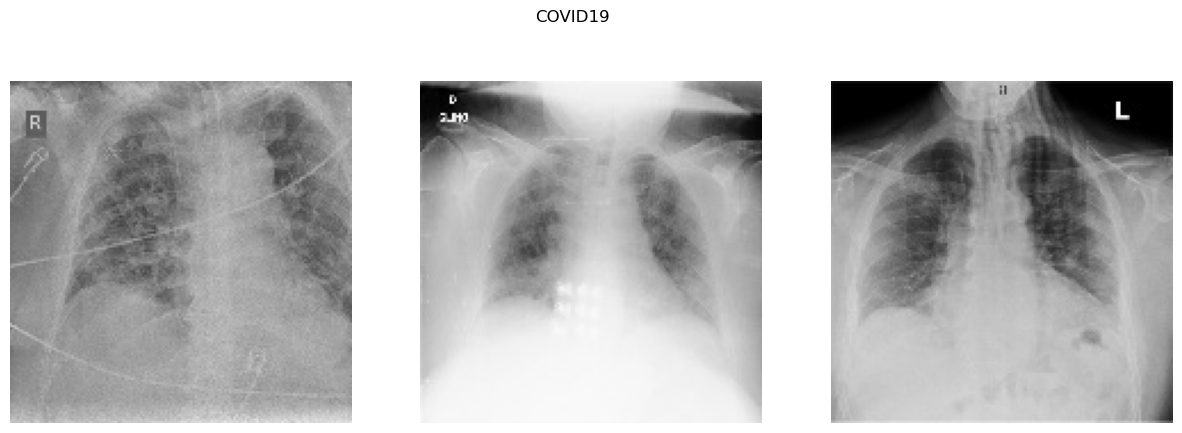

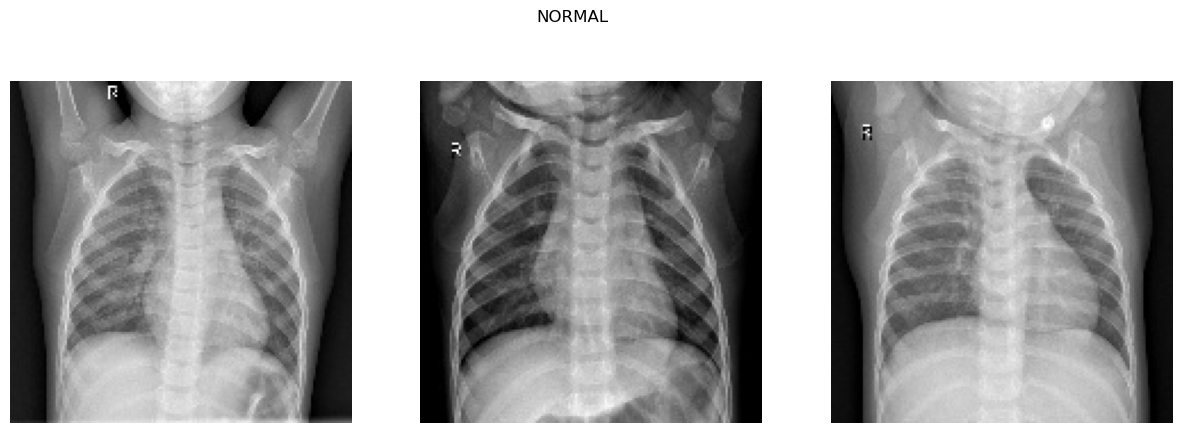

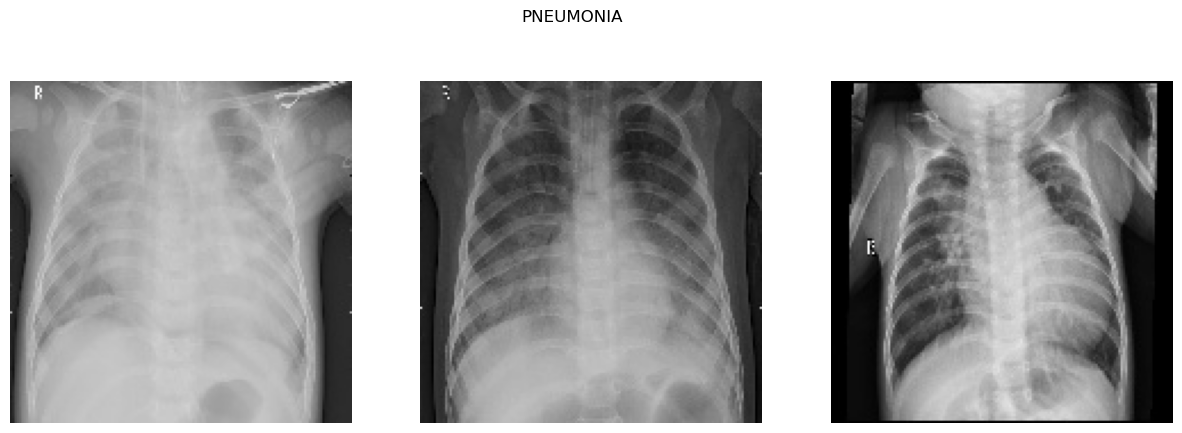

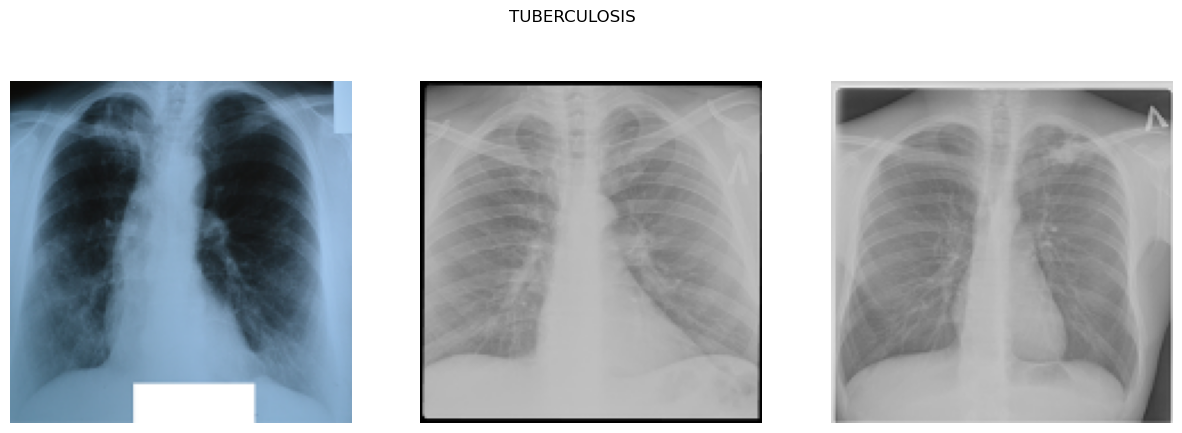

In [154]:
def display_images(dataset_path, labels, num_images=3):
    for label in labels:
        label_path = os.path.join(dataset_path, label)
        if os.path.isdir(label_path):
            files = [os.path.join(label_path, file) for file in os.listdir(label_path) if file.endswith(('.png', '.jpg', '.jpeg'))]
            plt.figure(figsize=(15, 5))
            plt.suptitle(label)
            for i in range(min(num_images, len(files))):
                img = Image.open(files[i])
                plt.subplot(1, num_images, i + 1)
                plt.imshow(img)
                plt.axis('off')
            plt.show()
        else:
            print(f"Directory for label {label} does not exist")

display_images(dataset_path, labels_to_display)


Gambar diatas merupakan contoh data dari masing-masing label. Pada percobaan ini label yang akan digunakan hanya label Covid19, Pneumonia, dan Normal.

## FUNGSI GLCM

- Konversi Gambar ke Grayscale: gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) digunakan untuk mengubah gambar berwarna (BGR) menjadi citra grayscale.

- Jarak dan Sudut: distances = [1] dan angles = [0°, 45°, 90°, 135° ] menentukan jarak dan sudut untuk GLCM. 

- Hitung GLCM: graycomatrix digunakan untuk menghitung GLCM dari gray_image dengan menggunakan jarak, sudut, dan parameter lain seperti jumlah level intensitas (256), simetris (symmetric=True), dan dinormalisasi (normed=True).

- Hitung Properti GLCM: graycoprops(glcm, prop) untuk setiap properti dalam properties (kontras, disimilaritas, homogenitas, energi, korelasi, ASM), dan kemudian diambil nilai rata-rata dengan .ravel()[0].

- Buat Dictionary Fitur: features = dict(zip(properties, glcm_props)) menggabungkan nama properti dengan nilai-nilai properti GLCM yang dihitung menjadi sebuah dictionary.

- Kembalikan Fitur: Fungsi mengembalikan dictionary features yang berisi nilai-nilai properti GLCM untuk gambar yang diberikan.

In [155]:
def calculate_glcm(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(gray_image, distances, angles, 256, symmetric=True, normed=True)

    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    glcm_props = [graycoprops(glcm, prop).ravel()[0] for prop in properties]


    features = dict(zip(properties, glcm_props))
    return features

## UNDER SAMPLING

- Iterasi Melalui Label: Loop for label in labels_to_display digunakan untuk mengakses setiap label kelas yang ingin ditampilkan.

- Path Label: label_path dibuat dengan menggabungkan dataset_path dengan label, yang mengarahkan ke direktori yang sesuai dengan label kelas saat ini.

- List Files: files = os.listdir(label_path) untuk mengambil daftar file dalam label_path.

- Hitung dan Simpan Sampel: class_samples[label] = len(files) menghitung jumlah file (sampel) dalam label_path dan menyimpan jumlahnya di class_samples menggunakan label sebagai kunci.

- Update Minimum Sampel: if len(files) < min_samples_per_class membandingkan jumlah sampel saat ini dengan min_samples_per_class. Jika lebih kecil, maka min_samples_per_class diperbarui dengan nilai tersebut.

- Iterasi dan Cetak: Loop for label, count in class_samples.items() digunakan untuk mengakses setiap pasangan kunci-nilai dalam class_samples. Di setiap iterasi, mencetak jumlah sampel untuk setiap label kelas.

- Cetak Minimum Sampel: Setelah iterasi selesai, mencetak jumlah minimum sampel (min_samples_per_class) yang telah dihitung sebelumnya.

In [156]:
for label in labels_to_display:
    label_path = os.path.join(dataset_path, label)
    files = os.listdir(label_path)
    class_samples[label] = len(files)
    if len(files) < min_samples_per_class:
        min_samples_per_class = len(files)

for label, count in class_samples.items():
    print(f"{label}: {count} sampel")

print(f"\nMinimum sampel: {min_samples_per_class} sampel")

COVID19: 460 sampel
NORMAL: 1000 sampel
PNEUMONIA: 1000 sampel
TUBERCULOSIS: 650 sampel

Minimum sampel: 460 sampel


#### Visualisasi Under Sampling

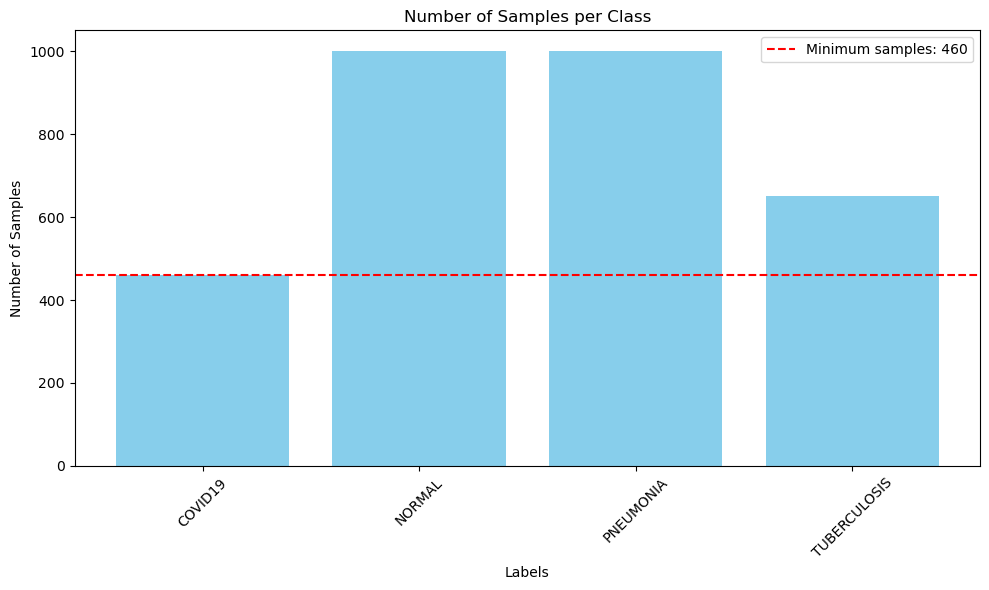

In [157]:
labels = list(class_samples.keys())
counts = list(class_samples.values())

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.axhline(min_samples_per_class, color='red', linestyle='--', label=f'Minimum samples: {min_samples_per_class}')
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

- List Kosong glcm_results: List glcm_results digunakan untuk menyimpan hasil perhitungan properti GLCM untuk setiap gambar dalam bentuk dictionary.

- Iterasi Melalui Label: Loop for label in labels_to_display digunakan untuk mengakses setiap label kelas yang ingin ditampilkan.

- Ambil Sampel: files = os.listdir(label_path)[:min_samples_per_class] digunakan untuk mengambil maksimal min_samples_per_class sampel dari setiap label kelas. Ini memastikan bahwa setiap kelas hanya menggunakan jumlah sampel yang sama untuk konsistensi analisis.

- Iterasi Melalui Sampel: Loop for file in files digunakan untuk mengakses setiap file (sampel) dalam label_path.

- Baca Gambar: image = cv2.imread(image_path) membaca gambar dari image_path menggunakan OpenCV.

- Hitung Properti GLCM: glcm_props = calculate_glcm(image) memanggil fungsi calculate_glcm untuk menghitung properti GLCM dari gambar yang dibaca.

- Tambahkan ke glcm_results: glcm_results.append({'Label': label, **glcm_props}) menambahkan dictionary yang berisi label kelas ('Label': label) dan properti GLCM (**glcm_props) ke dalam glcm_results.

- Cetak Jumlah Sampel: print(f'{label} : {len(files)} sampel') mencetak jumlah sampel yang digunakan dari setiap kelas untuk memastikan konsistensi dalam analisis.

- Buat DataFrame: df = pd.DataFrame(glcm_results) membuat DataFrame df dari glcm_results, yang berisi semua data hasil perhitungan properti GLCM untuk setiap gambar.

In [158]:
glcm_results = []

for label in labels_to_display:
    label_path = os.path.join(dataset_path, label)
    files = os.listdir(label_path)[:min_samples_per_class] 
    for file in files:
        image_path = os.path.join(label_path, file)
        image = cv2.imread(image_path)
        glcm_props = calculate_glcm(image)
        glcm_results.append({'Label': label, **glcm_props})
    print(f'{label} : {len(files)} sampel')

df = pd.DataFrame(glcm_results)
df

COVID19 : 460 sampel
NORMAL : 460 sampel
PNEUMONIA : 460 sampel
TUBERCULOSIS : 460 sampel


,Label,contrast,dissimilarity,homogeneity,energy,correlation,ASM
0,COVID19,111.471275,7.524161,0.137431,0.020896,0.916458,0.000437
1,COVID19,101.731544,3.767517,0.378664,0.055903,0.981583,0.003125
2,COVID19,107.955839,5.094989,0.296126,0.049488,0.986112,0.002449
3,COVID19,78.204832,5.919463,0.213885,0.029759,0.989011,0.000886
4,COVID19,141.646443,6.757584,0.237830,0.033777,0.975904,0.001141
...,...,...,...,...,...,...,...
1835,TUBERCULOSIS,38.311723,3.084161,0.359650,0.040433,0.979120,0.001635
1836,TUBERCULOSIS,453.840805,5.422103,0.368197,0.055609,0.885753,0.003092
1837,TUBERCULOSIS,38.311723,3.084161,0.359650,0.040433,0.979120,0.001635
1838,TUBERCULOSIS,83.334139,4.739955,0.324905,0.039428,0.987620,0.001555


In [159]:
output_glcm_path = 'balanced.csv'
df.to_csv(output_glcm_path, index=False)

print('Done')

Done


## TRAINING DATA

#### Menghapus Label Tuberculosis

In [176]:
filename = 'balanced.csv'
df = pd.read_csv(filename)

indices_to_drop = df[df["Label"] == "TUBERCULOSIS"].index
df = df.drop(indices_to_drop)
df

,Label,contrast,dissimilarity,homogeneity,energy,correlation,ASM
0,COVID19,111.471275,7.524161,0.137431,0.020896,0.916458,0.000437
1,COVID19,101.731544,3.767517,0.378664,0.055903,0.981583,0.003125
2,COVID19,107.955839,5.094989,0.296126,0.049488,0.986112,0.002449
3,COVID19,78.204832,5.919463,0.213885,0.029759,0.989011,0.000886
4,COVID19,141.646443,6.757584,0.237830,0.033777,0.975904,0.001141
...,...,...,...,...,...,...,...
1375,PNEUMONIA,165.280268,7.593557,0.184415,0.017827,0.968694,0.000318
1376,PNEUMONIA,175.890157,7.507696,0.209056,0.023144,0.971246,0.000536
1377,PNEUMONIA,160.064206,7.503758,0.208889,0.020076,0.971893,0.000403
1378,PNEUMONIA,155.114586,7.239418,0.187241,0.049756,0.973257,0.002476


- Inisialisasi LabelEncoder: label_encoder = LabelEncoder() digunakan untuk membuat objek LabelEncoder, yang akan digunakan untuk mengubah label kelas dari string menjadi nilai numerik.

- Encode Labels: df['Label'] = label_encoder.fit_transform(df['Label']) memanggil metode fit_transform dari LabelEncoder untuk mengubah kolom 'Label' dalam DataFrame df menjadi nilai numerik.

- Convert Labels to Categorical: y = to_categorical(df['Label']) menggunakan to_categorical dari Keras untuk mengubah nilai numerik yang telah diencode menjadi representasi one-hot encoding. Ini penting jika Anda akan menggunakan output kelas dalam model keras untuk klasifikasi multikelas.

- Prepare Features (X): X = df.drop('Label', axis=1).values menghilangkan kolom 'Label' dari DataFrame df dan mengambil nilai-nilai fitur yang tersisa sebagai X.

In [161]:
label_encoder = LabelEncoder()

df['Label'] = label_encoder.fit_transform(df['Label'])
y = to_categorical(df['Label'])
X = df.drop('Label', axis=1).values

- Inisialisasi StandardScaler: scaler = StandardScaler() digunakan untuk membuat objek StandardScaler, yang akan digunakan untuk penskalaan fitur.

- Penskalaan Fitur: X = scaler.fit_transform(X) menggunakan metode fit_transform dari StandardScaler untuk melakukan penskalaan pada data fitur X. Ini mengubah distribusi fitur sehingga memiliki mean 0 dan varians 1.

- Reshaping X: X = X.reshape((X.shape[0], X.shape[1], 1)) mengubah bentuk X menjadi bentuk yang sesuai untuk input ke jaringan saraf tiruan dengan menggunakan Keras. Dalam hal ini, X.shape[0] adalah jumlah sampel, X.shape[1] adalah jumlah fitur setelah penskalaan, dan 1 menunjukkan bahwa setiap sampel memiliki satu saluran atau dimensi.

In [162]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = X.reshape((X.shape[0], X.shape[1], 1))

- Pemanggilan train_test_split: train_test_split(X, y, test_size=0.3, random_state=50) digunakan untuk membagi data menjadi empat subset:

    - X_train: Fitur latihan, yang digunakan untuk melatih model.

    - X_test: Fitur uji, yang digunakan untuk menguji kinerja model.

    - y_train: Target latihan, yang sesuai dengan X_train.

    - y_test: Target uji, yang sesuai dengan X_test.

- Parameter test_size: test_size=0.3 menunjukkan bahwa data uji akan mencakup 30% dari seluruh dataset, sementara data latih akan mencakup 70%.

- Parameter random_state: random_state=50 digunakan untuk menetapkan seed untuk generator nomor acak, yang memastikan pembagian data yang sama jika kode dieksekusi ulang dengan parameter yang sama.



In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

- Inisialisasi Sequential Model: model = Sequential() digunakan untuk membuat model neural network sekuen. Dalam model ini, lapisan-lapisan ditambahkan satu per satu secara berurutan.

- Lapisan-lapisan Dense: Model Anda terdiri dari beberapa lapisan Dense dengan berbagai fungsi aktivasi:

    - Dense(128, input_dim=X_train.shape[1], activation='relu'): Lapisan pertama dengan 128 unit, yang menerima input sesuai dengan jumlah fitur X_train.shape[1] dan menggunakan aktivasi ReLU.
    - Dropout(0.2): Dropout dengan tingkat dropout 0.2, untuk mencegah overfitting dengan secara acak mengabaikan 20% unit selama pelatihan.
    - Berbagai lapisan Dense dengan fungsi aktivasi seperti 'elu', 'softsign', 'relu', dan 'sigmoid'.
    - Dense(len(label_encoder.classes_), activation='softmax'): Lapisan output dengan jumlah unit sesuai dengan jumlah kelas yang diencode (len(label_encoder.classes_)), dan menggunakan aktivasi softmax untuk output probabilitas kelas.

- Summary Model: model.summary() digunakan untuk mencetak ringkasan arsitektur model, termasuk jumlah parameter yang dapat dioptimalkan.

- Kompilasi Model: model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) mengonfigurasi proses pelatihan model. Dalam hal ini:

- optimizer='adam' memilih algoritma optimasi Adam untuk menyesuaikan bobot jaringan selama pelatihan.

- loss='categorical_crossentropy' adalah fungsi kerugian yang dipilih untuk tugas klasifikasi multikelas.

- metrics=['accuracy'] menentukan metrik evaluasi yang digunakan untuk mengevaluasi kinerja model selama pelatihan dan evaluasi.

In [178]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='elu'))
model.add(Dense(32, activation='softsign'))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='softsign'))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='elu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

d:\App\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_87 (Dense)                │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,619 (61.01 KB)

 Trainable params: 15,619 (61.01 KB)

 Non-trainable params: 0 (0.00 B)

- model.fit: Metode fit digunakan untuk melatih model neural network. Parameter yang digunakan adalah sebagai berikut:
    - X_train dan y_train: Data fitur dan target untuk pelatihan model.
    - epochs=100: Jumlah epochs atau iterasi lengkap dari data yang akan digunakan selama pelatihan.
    - validation_data=(X_test, y_test): Data uji yang digunakan untuk evaluasi kinerja model setiap akhir epoch.
    - verbose=1: Parameter ini menentukan tingkat detail informasi yang ditampilkan selama pelatihan. verbose=1 menampilkan progress bar dengan detail epoch dan metrik evaluasi.

In [179]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.3523 - loss: 1.1999 - val_accuracy: 0.5797 - val_loss: 1.0104
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5856 - loss: 0.9693 - val_accuracy: 0.6014 - val_loss: 0.8309
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6181 - loss: 0.8173 - val_accuracy: 0.6353 - val_loss: 0.7743
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6678 - loss: 0.7274 - val_accuracy: 0.6353 - val_loss: 0.7387
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6501 - loss: 0.7498 - val_accuracy: 0.6184 - val_loss: 0.7180
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6380 - loss: 0.7185 - val_accuracy: 0.6546 - val_loss: 0.7044
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6778 - loss: 0.6763 - val_accuracy: 0.6546 - val_loss: 0.7004
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6727 - loss: 0.6910 - val_accuracy: 0.6739 - 

- model.evaluate: Metode evaluate digunakan untuk mengevaluasi model pada data uji. Parameter yang digunakan adalah:

    X_test dan y_test: Data fitur dan target untuk evaluasi model.

- print('Test loss:', evaluation[0]): Mencetak nilai loss dari evaluasi model pada data uji.
- print('Test accuracy:', evaluation[1]): Mencetak nilai akurasi dari evaluasi model pada data uji.

In [180]:
evaluation = model.evaluate(X_test, y_test)
print('Test loss:', evaluation[0])
print('Test accuracy:', evaluation[1])

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7986 - loss: 0.5584 
Test loss: 0.53876131772995
Test accuracy: 0.804347813129425


#### Visualisai Model

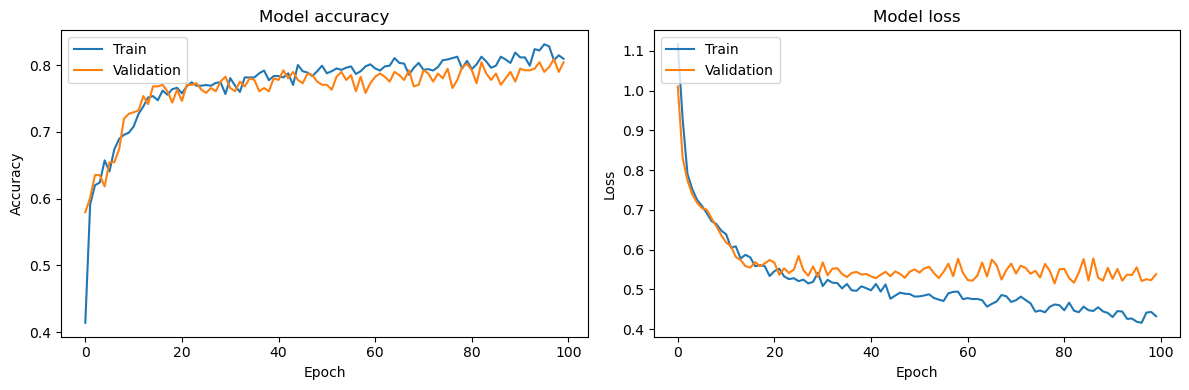

In [181]:
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

plot_history(history)

- class_names: class_names adalah daftar yang berisi nama kelas yang diprediksi. Dalam konteks ini, Anda mendefinisikan kelas 'covid', 'normal', dan 'pneumonia'.

- Generate Predictions:

    - y_pred = model.predict(X_test): Menggunakan model yang telah dilatih (model) untuk melakukan prediksi pada data uji (X_test). y_pred akan berisi prediksi probabilitas untuk setiap kelas.
    - y_pred_classes = np.argmax(y_pred, axis=1): Menggunakan np.argmax untuk mengambil indeks kelas dengan probabilitas tertinggi dari y_pred. Ini menghasilkan prediksi kelas yang konkret untuk setiap sampel.
    - y_true = np.argmax(y_test, axis=1): Menggunakan np.argmax untuk mendapatkan kelas yang sebenarnya dari y_test, yang berisi label yang sebenarnya dari data uji.

In [182]:
class_names = ['covid', 'normal', 'pneumonia']

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


- print('Classification Report'): Ini adalah perintah untuk mencetak header atau judul laporan klasifikasi.

- classification_report(y_true, y_pred_classes, target_names=class_names):

    - y_true: Label yang sebenarnya dari data uji (y_test).
    - y_pred_classes: Prediksi kelas yang dihasilkan oleh model untuk data uji.
    - target_names: Nama-nama kelas yang akan ditampilkan dalam laporan. Dalam kasus Anda, class_names berisi daftar nama kelas, seperti 'covid', 'normal', 'pneumonia'.

In [183]:
print('Classification Report')
print(classification_report(y_true, y_pred_classes, target_names=class_names))

Classification Report
              precision    recall  f1-score   support

       covid       0.80      0.75      0.77       135
      normal       0.88      0.88      0.88       141
   pneumonia       0.74      0.78      0.76       138

    accuracy                           0.80       414
   macro avg       0.80      0.80      0.80       414
weighted avg       0.81      0.80      0.80       414



#### Visualisasi Confusion Matrix

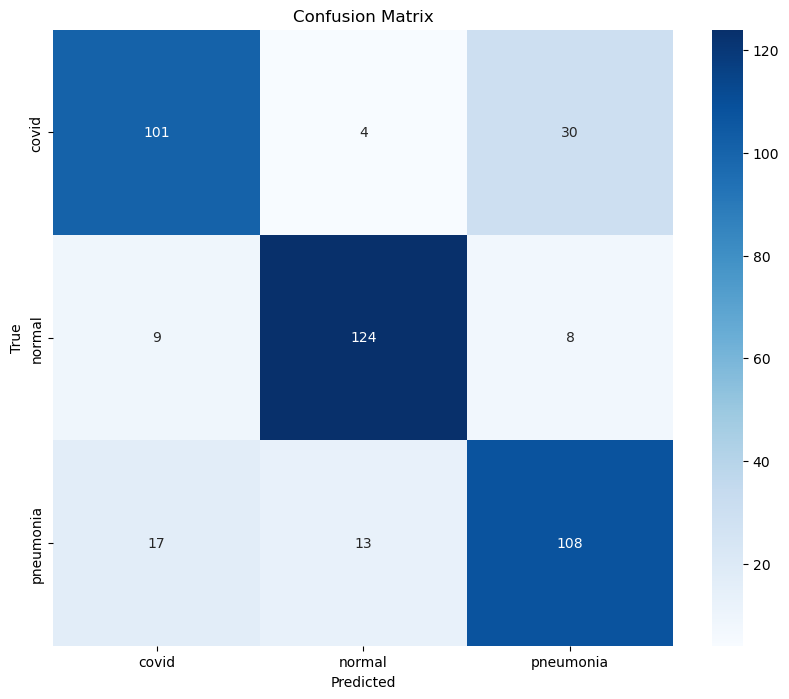

In [184]:
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### Save Model

In [185]:
model.save('model_glcm_cnn.keras')

----------------------------------------------------------------------------------------------------------------------



----------------------------------------------------------------------------------------------------------------------

## TESTING

In [191]:
glcm_test_results = []
def test_glcm(folder_path):
    class_names = sorted(os.listdir(folder_path))
    for class_name in class_names:
        #print(f"Class: {class_name}")
        class_dir = os.path.join(folder_path, class_name)
        image_files = os.listdir(class_dir)
        random.shuffle(image_files)
        
        for image_file in image_files:
            img_path = os.path.join(class_dir, image_file)
            img = cv2.imread(img_path)
            glcm_props = calculate_glcm(img) 
            glcm_props['Label'] = class_name
            glcm_test_results.append(glcm_props)
    
    return glcm_test_results

In [192]:
folder_path = r"D:\Lecture\Fitur-Pola\tubes\datasets\train"
glcm_test_results = test_glcm(folder_path)

df_test = pd.DataFrame(glcm_test_results)
#df_test

In [193]:
indices_to_drop = df_test[df_test["Label"] == "TUBERCULOSIS"].index
df_test = df_test.drop(indices_to_drop)
#df_test

In [190]:
import tensorflow as tf
import pandas as pd
import numpy as np

model_path = 'model_glcm_cnn.keras'
model = tf.keras.models.load_model(model_path)

def predict(model, data):
    features = data[['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']].values
    predictions = model.predict(features)
    predicted_classes = np.argmax(predictions, axis=1)
    label_map = {0: 'COVID19', 1: 'NORMAL', 2: 'PNEUMONIA'}
    predicted_labels = [label_map[idx] for idx in predicted_classes]
    return predicted_labels

df_test = pd.DataFrame(df_test)
predicted_labels = predict(model, df_test)
df_test['Predicted_Label'] = predicted_labels
print(df_test[['Label', 'Predicted_Label']])
save_csv = df_test.to_csv('glcm_test_results.csv', index=False)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
          Label Predicted_Label
0       COVID19         COVID19
1       COVID19         COVID19
2       COVID19         COVID19
3       COVID19         COVID19
4       COVID19         COVID19
...         ...             ...
2455  PNEUMONIA         COVID19
2456  PNEUMONIA         COVID19
2457  PNEUMONIA         COVID19
2458  PNEUMONIA         COVID19
2459  PNEUMONIA         COVID19

[2460 rows x 2 columns]
